## Anomaly Detection

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import dates as md

In [91]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

In [92]:
data.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


Text(0.5, 1.0, 'Original Data')

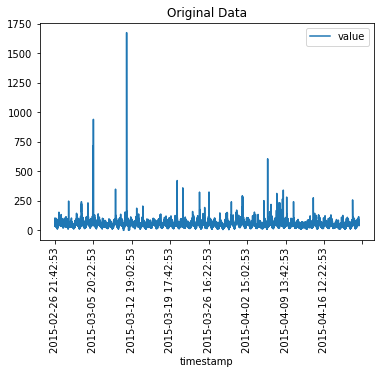

In [93]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')
plt.title("Original Data")

Splitting the data into train and validation. Preparing the data for the model training.

In [94]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

Considering 36 previous values for the input.

In [95]:
n_timesteps = 36
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5


In [96]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)

y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14206, 36, 1), (14206, 5, 1), (1542, 36, 1), (1542, 5, 1))

Autoencoder with LSTM. The size of the input data is 50 initially, which is compressed to 25 and then later the model tries to rebuild the original input to the original size of 50.

In [97]:

dimensions = 50
def AutoencoderLSTM(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, 1))
     
    
    x = LSTM(dimensions, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features))(i)
    x = Dropout(0.2)(x)

    x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
    x = LSTM(dimensions, activation='relu')(x)

    # output = layers.TimeDistributed(Dense(n_timesteps))(x)
    output = Dense(n_timesteps)(x)
    model = Model(inputs=i, outputs=output)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model
  

model = AutoencoderLSTM(n_timesteps,n_features)
model.summary()


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 36, 50)            10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 36, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 36, 25)            7600      
_________________________________________________________________
dropout_9 (Dropout)          (None, 36, 25)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 36, 25)            5100      
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)               

In [98]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=36,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)


Epoch 1/50
356/356 [==============================] - 77s 215ms/step - loss: 41.4878 - val_loss: 45.5647
Epoch 2/50
356/356 [==============================] - 75s 212ms/step - loss: 25.9688 - val_loss: 20.6618
Epoch 3/50
356/356 [==============================] - 76s 213ms/step - loss: 18.3055 - val_loss: 17.0547
Epoch 4/50
356/356 [==============================] - 73s 206ms/step - loss: 16.4862 - val_loss: 19.0974
Epoch 5/50
356/356 [==============================] - 72s 203ms/step - loss: 15.4752 - val_loss: 16.8769
Epoch 6/50
356/356 [==============================] - 72s 203ms/step - loss: 14.9613 - val_loss: 15.4064
Epoch 7/50
356/356 [==============================] - 74s 209ms/step - loss: 14.7842 - val_loss: 16.7567
Epoch 8/50
356/356 [==============================] - 73s 205ms/step - loss: 14.8571 - val_loss: 14.8765
Epoch 9/50
356/356 [==============================] - 73s 205ms/step - loss: 14.6649 - val_loss: 12.9906
Epoch 10/50
356/356 [==============================] - 

In [99]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(14206, 36)

In [100]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(X_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

14206

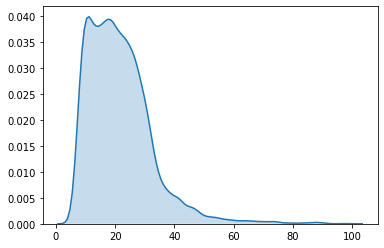

In [101]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

In [102]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(21.603751752313975, 10.912525159844645)

In [103]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

In [104]:
y_val_pred = model.predict(X_val)
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
val_errors = [mean_absolute_error(X_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]
print(results)


[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

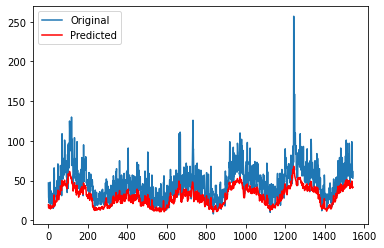

In [105]:
import matplotlib.pyplot as plt

plt.plot(X_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

In [106]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

In [108]:
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(X_val[i][0])
print(plot_y)

[array([47]), array([52]), array([65]), array([71]), array([73]), array([78]), array([59]), array([57]), array([76]), array([101]), array([97]), array([77]), array([60]), array([71]), array([67]), array([75]), array([75]), array([67]), array([61]), array([54]), array([62]), array([48]), array([35]), array([50]), array([83]), array([48]), array([40]), array([95]), array([84]), array([58]), array([58]), array([53]), array([49]), array([51]), array([46]), array([50]), array([43]), array([51]), array([48]), array([29]), array([37]), array([43]), array([33]), array([30]), array([35]), array([25]), array([30]), array([31]), array([15]), array([22]), array([22]), array([28]), array([38]), array([36]), array([20]), array([25]), array([19]), array([23]), array([35]), array([35]), array([25]), array([27]), array([24]), array([25]), array([19]), array([26]), array([27]), array([21]), array([24]), array([25]), array([27]), array([34]), array([30]), array([31]), array([32]), array([36]), array([29]

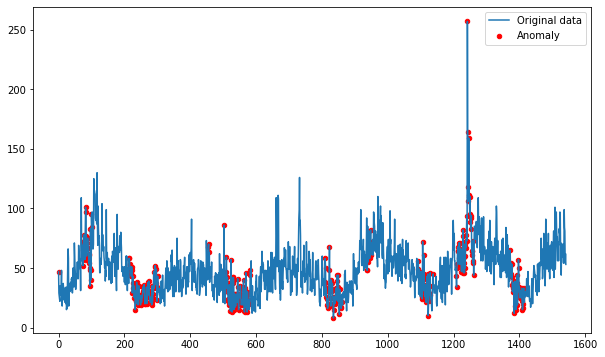

In [111]:
plt.figure(figsize=(10,6))
plt.plot(X_val[:,0].squeeze(),label='Original data')
plt.scatter(plot_x,plot_y, color="r",s=20,label='Anomaly')
plt.legend()

Plots between training and validation loss

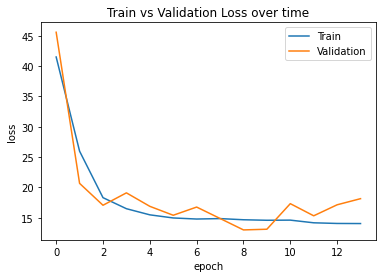

In [110]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')